In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import  train_test_split

import utils

import warnings
warnings.filterwarnings('ignore')

# Предобработка данных

In [2]:
dataframe = pd.read_csv('telecom_churn.csv')
dataframe['Area code'] = dataframe['Area code'].astype(str)
OUTPUT_COLUMN = 'Churn'
to_drop = ['State']
categorical = ['Area code', 'International plan', 'Voice mail plan']

dataframe = utils.preprocess_df(dataframe, OUTPUT_COLUMN, categorical, to_drop= to_drop, resample=True)


In [3]:
# Разделение на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(columns=OUTPUT_COLUMN), dataframe[OUTPUT_COLUMN])

In [4]:
# Точность каждого из методов.
# Метод опорных векторов - лучший результат из предыдущей работы
results = {'Метод опорных векторов': 0.909}

# Дерево решений

In [5]:
clf = DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_features': ['sqrt', 'log2']}
clf = utils.grid_search(clf, params, x_train, y_train)
predicted = clf.predict(x_test)
metrics = utils.get_classification_metrics(y_test, predicted)
results['Дерево решений'] = metrics['Accuracy']

In [6]:
# Обрезка дерева
ccp_alphas = clf.cost_complexity_pruning_path(x_train, y_train).ccp_alphas
best_accuracy = 0
for alpha in ccp_alphas:
    pruned_clf = DecisionTreeClassifier()
    pruned_clf.set_params(**clf.get_params())
    pruned_clf.set_params(**{"ccp_alpha": alpha})
    pruned_clf.fit(x_train, y_train)
    accuracy = utils.get_classification_metrics(y_test, pruned_clf.predict(x_test))['Accuracy']
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_alpha = alpha
        pruned_tree_clf = pruned_clf
#pruned_tree_clf = best_clf
metrics = utils.get_classification_metrics(y_test, pruned_tree_clf.predict(x_test))
results['Обрезанное дерево решений'] = metrics['Accuracy']

# Бэггинг

In [7]:
# Использует обрезанное дерево из предыдущего раздела
params = {'n_estimators': range(3, 11)}
bagging_clf = utils.grid_search(BaggingClassifier(pruned_tree_clf), params, x_train, y_train)
predicted = bagging_clf.predict(x_test)
metrics = utils.get_classification_metrics(y_test, predicted)
results['Бэггинг'] = metrics['Accuracy']

# Бустинг

In [8]:
params = {'learning_rate': [x/100 for x in range(1, 110, 20)], 'n_estimators': range(20, 200, 40),}
clf = utils.grid_search(GradientBoostingClassifier(), params, x_train, y_train)
predicted = bagging_clf.predict(x_test)
metrics = utils.get_classification_metrics(y_test, predicted)
results['Бустинг'] = metrics['Accuracy']

# Стэкинг

In [9]:
# Включает в себя модели из предыдущей работы, а также дерево решений, полученное выше

# Модели и настраиваемые гиперпараметры из предыдущей работы
models_data = [{'name': 'К-ближайших соседей', 'model': KNeighborsClassifier, 'params': {'n_neighbors':range(1, 11), 'weights':('uniform', 'distance'),
              'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute')}},

              {'name': 'Логистическая регрессия', 'model': LogisticRegression,  'params': {'C':range(1, 10), 'penalty':(None, 'l1', 'l2', 'elasticnet'), 
              'solver':(['saga']), 'l1_ratio':([0.5])}},

              {'name': 'Метод опорных векторов', 'model':  SVC, 'params': {'kernel':('rbf', 'linear', 'poly'), 'C':(range(1, 10))}}
]
stacking_models = [(model_data['name'], utils.grid_search(model_data['model'](), model_data['params'], x_train, y_train)) for model_data in models_data]
stacking_models.append(("Обрезанное дерево", pruned_tree_clf))
stacking_clf = StackingClassifier(stacking_models)
stacking_clf.fit(x_train, y_train)
predicted = stacking_clf.predict(x_test)
metrics = utils.get_classification_metrics(y_test, predicted)
results['Стекинг'] = metrics['Accuracy']

In [10]:
results

{'Метод опорных векторов': 0.909,
 'Дерево решений': 0.8796886058032555,
 'Обрезанное дерево решений': 0.9263977353149327,
 'Бэггинг': 0.940552016985138,
 'Бустинг': 0.940552016985138,
 'Стекинг': 0.9532908704883227}

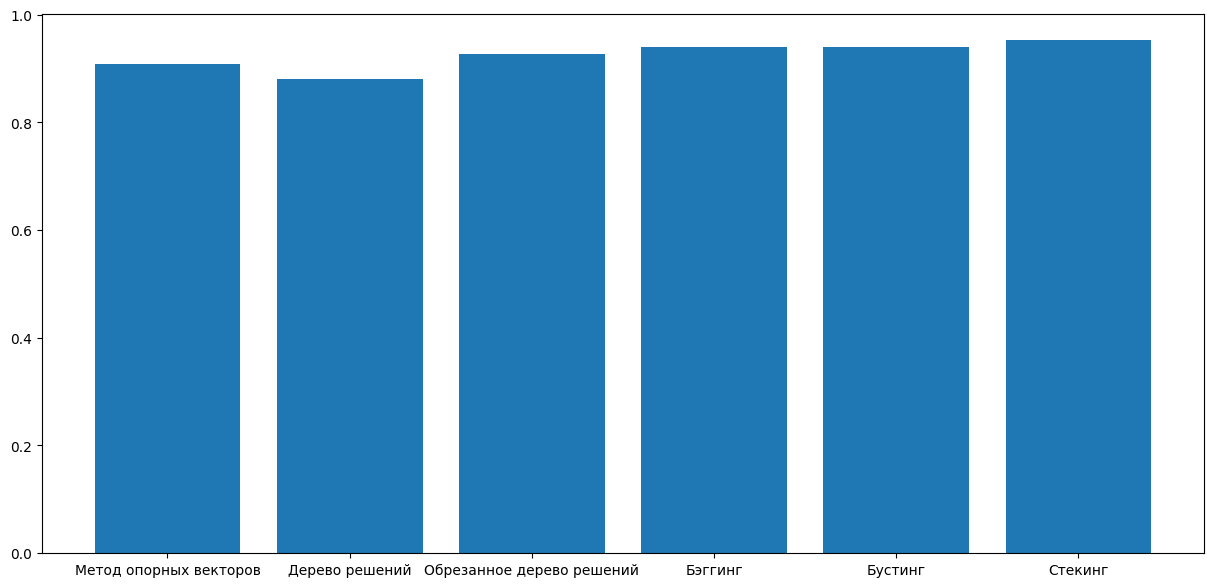

In [11]:
plt.figure(figsize=(15, 7))
plt.bar(results.keys(), results.values())
plt.show()